<a href="https://colab.research.google.com/github/jajapuramshivasai/Neuromorphic-LSM-QT/blob/main/proof_of_concept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install pennylane
!pip install Brian2
!pip install snntorch

WARNING    The object 'synapses_4' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/tmp/ipython-input-1039939047.py', line 92, in <cell line: 0>
    recurrent_syn = Synapses(Reservoir, Reservoir, on_pre='I_syn += w') [brian2.core.base.unused_brian_object]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 3.0 MB/s eta 0:00:00


Hyperparameters:
Number of qubits: 3
Reservoir dimension: 100
Training samples max: 100
Sample step size: 5


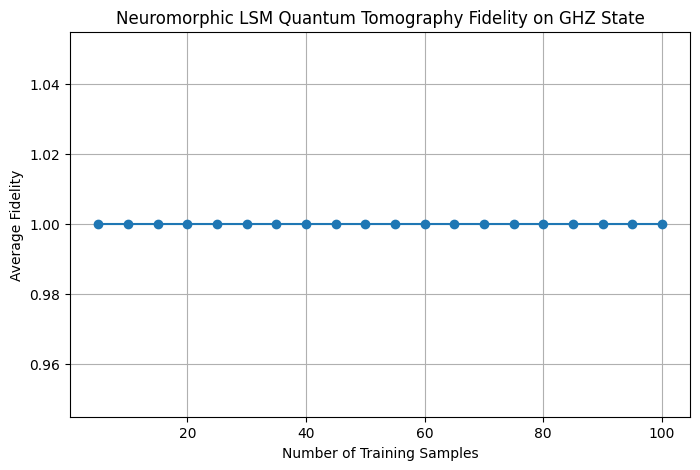

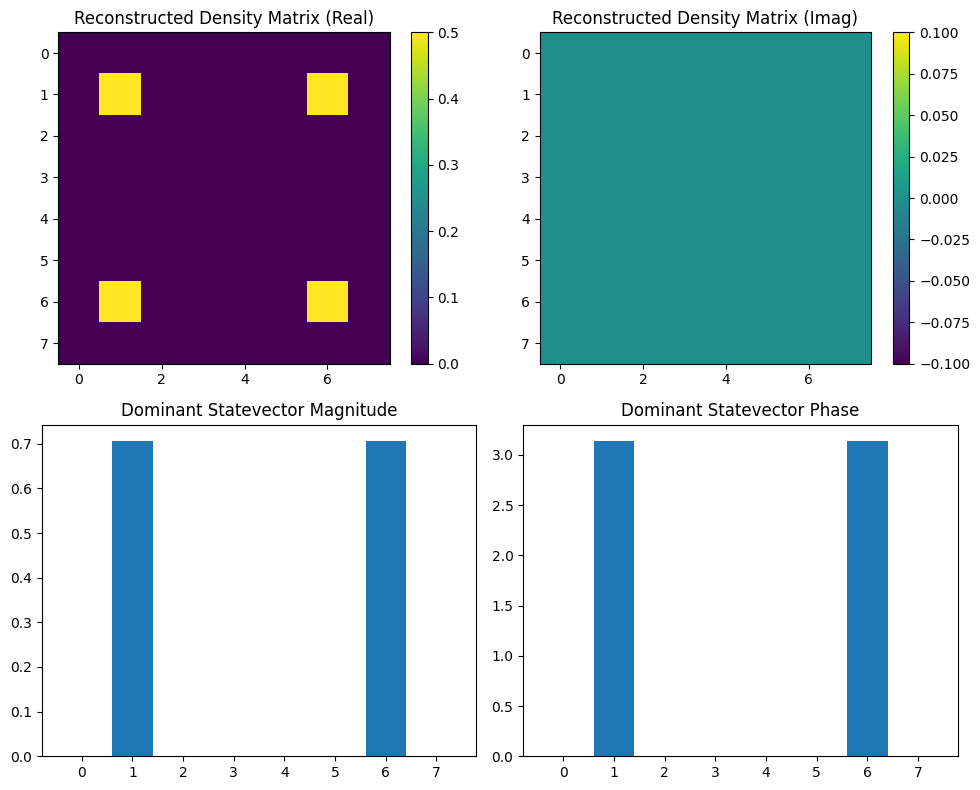

In [12]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

# Hyperparameters
num_qubits = 3
reservoir_dim = 100
max_samples = 100
sample_step = 5

print("Hyperparameters:")
print(f"Number of qubits: {num_qubits}")
print(f"Reservoir dimension: {reservoir_dim}")
print(f"Training samples max: {max_samples}")
print(f"Sample step size: {sample_step}")

# PennyLane device
dev = qml.device("default.qubit", wires=num_qubits)

# GHZ state preparation circuit
@qml.qnode(dev)
def ghz_state():
    qml.Hadamard(wires=0)
    for i in range(num_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    qml.PauliX(wires=num_qubits - 1)
    return qml.state()

# Simple neuromorphic LSM implementation
class SimpleNeuromorphicLSM:
    def __init__(self, input_dim, reservoir_dim):
        self.W_in = np.random.normal(0, 1, (reservoir_dim, input_dim))
        self.W_res = np.random.normal(0, 1, (reservoir_dim, reservoir_dim))
        spectral_radius = 1.2
        self.W_res *= spectral_radius / np.max(np.abs(np.linalg.eigvals(self.W_res)))
        self.reservoir_dim = reservoir_dim

    def run(self, inputs):
        n_samples = inputs.shape[0]
        res_states = np.zeros((n_samples, self.reservoir_dim))
        res = np.zeros(self.reservoir_dim)
        for i in range(n_samples):
            res = np.tanh(self.W_in @ inputs[i] + self.W_res @ res)
            res_states[i] = res
        return res_states

# Convert statevector to density matrix
def state_to_dm(state_vec):
    return np.outer(state_vec, np.conj(state_vec))

# Compute fidelity batch
def fidelity_batch(true_dm, pred_dm, dim=2**num_qubits):
    fidelities = []
    for t, p in zip(true_dm, pred_dm):
        t_dm = t[:dim*dim].reshape((dim, dim)) + 1j * t[dim*dim:].reshape((dim, dim))
        p_dm = p[:dim*dim].reshape((dim, dim)) + 1j * p[dim*dim:].reshape((dim, dim))
        f = qml.math.fidelity(t_dm, p_dm)
        fidelities.append(f)
    return np.array(fidelities)

# Lists for sample size and fidelity results
num_samples_list = list(range(sample_step, max_samples + 1, sample_step))
avg_fidelities = []

for num_samples in num_samples_list:
    # Generate GHZ states (all the same, repeated)
    ghz_states = np.array([ghz_state() for _ in range(num_samples)])
    # Density matrices
    dms = np.array([state_to_dm(st) for st in ghz_states])
    # Flatten input and target
    inputs = np.hstack([ghz_states.real, ghz_states.imag])
    targets = np.hstack([dms.real.reshape(num_samples, -1), dms.imag.reshape(num_samples, -1)])

    # Initialize neuromorphic LSM and run
    lsm = SimpleNeuromorphicLSM(input_dim=inputs.shape[1], reservoir_dim=reservoir_dim)
    res_states = lsm.run(inputs)

    # Ridge regression training
    reg = Ridge()
    reg.fit(res_states, targets)

    # Predict and evaluate fidelity
    pred_targets = reg.predict(res_states)
    fidelities = fidelity_batch(targets, pred_targets)
    avg_fidelities.append(np.mean(fidelities))

# Plot average fidelity vs number of training samples
plt.figure(figsize=(8, 5))
plt.plot(num_samples_list, avg_fidelities, marker='o')
plt.title('Neuromorphic LSM Quantum Tomography Fidelity on GHZ State')
plt.xlabel('Number of Training Samples')
plt.ylabel('Average Fidelity')
plt.grid(True)
plt.show()

# Visualize the reconstructed state and density matrix for the last (max) sample count
dim = 2**num_qubits
pred_dm_complex = pred_targets[0, :dim*dim].reshape((dim, dim)) + 1j * pred_targets[0, dim*dim:].reshape((dim, dim))

# Extract dominant eigenvector (closest statevector)
eigvals, eigvecs = np.linalg.eigh(pred_dm_complex)
dominant_statevector = eigvecs[:, np.argmax(eigvals)]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

im1 = axs[0, 0].imshow(pred_dm_complex.real, cmap='viridis')
axs[0, 0].set_title('Reconstructed Density Matrix (Real)')
plt.colorbar(im1, ax=axs[0, 0])

im2 = axs[0, 1].imshow(pred_dm_complex.imag, cmap='viridis')
axs[0, 1].set_title('Reconstructed Density Matrix (Imag)')
plt.colorbar(im2, ax=axs[0, 1])

axs[1, 0].bar(range(dim), np.abs(dominant_statevector))
axs[1, 0].set_title('Dominant Statevector Magnitude')

axs[1, 1].bar(range(dim), np.angle(dominant_statevector))
axs[1, 1].set_title('Dominant Statevector Phase')

plt.tight_layout()
plt.show()


In [19]:
# Installation (run if not installed):
# pip install snntorch pennylane scikit-learn matplotlib torch

import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate, spikegen
import pennylane as qml
from pennylane import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_qubits = 3
input_size = 2 ** num_qubits
reservoir_size = 100
time_steps = 50
num_training_samples = 50
measurement_shots = 1000
max_rate_hz = 100  # max spike rate for encoding

print(f"Device: {device}")
print(f"Qubits: {num_qubits}, Reservoir size: {reservoir_size}, Time steps: {time_steps}, Samples: {num_training_samples}")

# PennyLane quantum measurement sampling
dev_meas = qml.device("default.qubit", wires=num_qubits, shots=measurement_shots)
dev_state = qml.device("default.qubit", wires=num_qubits, shots=None)

@qml.qnode(dev_meas)
def sample_measurement():
    qml.Hadamard(wires=0)
    for i in range(num_qubits - 1):
        qml.CNOT(wires=[i, i+1])
    return qml.sample(wires=range(num_qubits))

@qml.qnode(dev_state)
def prepare_state():
    qml.Hadamard(wires=0)
    for i in range(num_qubits - 1):
        qml.CNOT(wires=[i, i+1])
    return qml.state()

def state_to_density_matrix(state_vec):
    return np.outer(state_vec, np.conj(state_vec))

# Encode measurement frequency as spike trains for snntorch PoissonGenerator
def samples_to_rates(samples, max_rate=max_rate_hz):
    counts = {}
    total = len(samples)
    for s in samples:
        bitstr = ''.join(str(int(b)) for b in s)
        counts[bitstr] = counts.get(bitstr, 0) + 1
    freqs = [counts.get(f"{i:0{num_qubits}b}", 0)/total for i in range(2**num_qubits)]
    return torch.tensor(freqs,dtype=torch.float) * max_rate / 1000  # convert to spike probability per ms

# Define spiking reservoir layer using snntorch LIF neurons
class SNNReservoir(nn.Module):
    def __init__(self, input_size, reservoir_size, spike_grad=surrogate.fast_sigmoid(slope=25)):
        super().__init__()
        self.fc_in = nn.Linear(input_size, reservoir_size)
        self.lif = snn.Leaky(beta=0.9, spike_grad=spike_grad, init_hidden=True)

    def forward(self, x, mem=None):
        cur = self.fc_in(x)
        spk, mem = self.lif(cur, mem)
        return spk, mem

# Initialize reservoir
reservoir = SNNReservoir(input_size, reservoir_size).to(device)

# Simulation of spike trains over time and collection of reservoir firing rates for regression training
reservoir_states = []
target_density_mats = []

for _ in range(num_training_samples):
    # Generate measurement samples and encode as rates
    meas_samples = sample_measurement()
    spike_rates = samples_to_rates(meas_samples).to(device)

    # Generate Poisson spike trains for input over time steps
    inputs = spikegen.poisson(spike_rates.repeat(time_steps, 1), dt=1.0, device=device)  # shape (T, input_size)

    mem = None
    spk_counter = torch.zeros(reservoir_size, device=device)
    for t in range(time_steps):
        spk, mem = reservoir(inputs[t].unsqueeze(0), mem)
        spk_counter += spk.squeeze(0)

    # Average firing rate over time steps for regression feature
    firing_rate = spk_counter / time_steps
    reservoir_states.append(firing_rate.cpu())

    # True density matrix target
    true_state = prepare_state()
    dm = state_to_density_matrix(true_state)
    target_density_mats.append(dm)

reservoir_states = torch.stack(reservoir_states).numpy()
target_density_mats = np.array(target_density_mats)

# Flatten density matrices for ridge regression targets
targets = np.hstack([target_density_mats.real.reshape(num_training_samples, -1), target_density_mats.imag.reshape(num_training_samples, -1)])

# Ridge regression training
reg = Ridge()
reg.fit(reservoir_states, targets)
predictions = reg.predict(reservoir_states)

# Fidelity computation function
def fidelity_batch(true_dm, pred_dm, dim=2**num_qubits):
    fidelities = []
    for t, p in zip(true_dm, pred_dm):
        t_dm = t[:dim*dim].reshape((dim, dim)) + 1j * t[dim*dim:].reshape((dim, dim))
        p_dm = p[:dim*dim].reshape((dim, dim)) + 1j * p[dim*dim:].reshape((dim, dim))
        fidelities.append(qml.math.fidelity(t_dm, p_dm))
    return np.array(fidelities)

fidelities = fidelity_batch(targets, predictions)
print(f"Average fidelity on training samples: {np.mean(fidelities):.4f}")

# Visualization of reconstructed density matrix and dominant eigenvector
dim = 2 ** num_qubits
pred_dm = predictions[0, :dim*dim].reshape((dim, dim)) + 1j * predictions[0, dim*dim:].reshape((dim, dim))
eigvals, eigvecs = np.linalg.eigh(pred_dm)
dominant_vec = eigvecs[:, np.argmax(eigvals)]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

im = axs[0, 0].imshow(pred_dm.real, cmap='viridis')
axs[0, 0].set_title("Reconstructed Density Matrix (Real)")
plt.colorbar(im, ax=axs[0, 0])

im = axs[0, 1].imshow(pred_dm.imag, cmap='viridis')
axs[0, 1].set_title("Reconstructed Density Matrix (Imag)")
plt.colorbar(im, ax=axs[0, 1])

axs[1, 0].bar(range(dim), np.abs(dominant_vec))
axs[1, 0].set_title("Dominant Statevector Magnitude")

axs[1, 1].bar(range(dim), np.angle(dominant_vec))
axs[1, 1].set_title("Dominant Statevector Phase")

plt.tight_layout()
plt.show()


Device: cpu
Qubits: 3, Reservoir size: 100, Time steps: 50, Samples: 50


AttributeError: module 'snntorch.spikegen' has no attribute 'poisson'

Device: cpu
Qubits: 3, Reservoir size: 100, Time steps: 50, Samples: 50
Average fidelity: 1.0000
Std fidelity: 0.0000


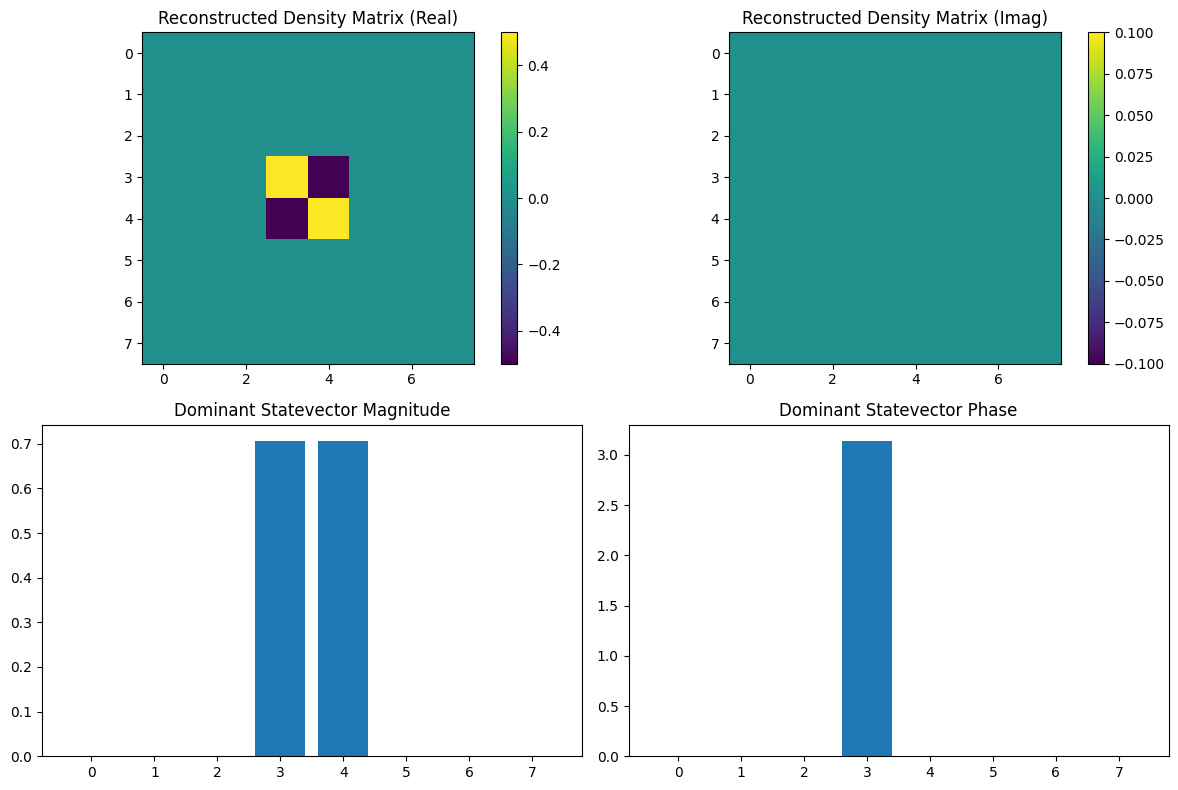

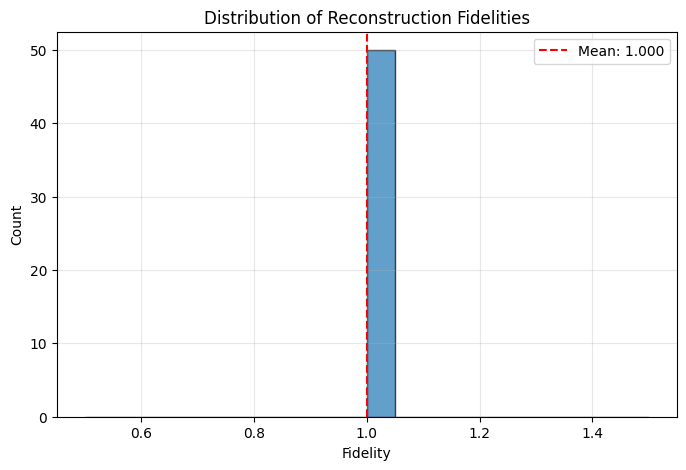

In [22]:
# Installation (run if not installed):
# pip install snntorch pennylane scikit-learn matplotlib torch

import torch
import torch.nn as nn
import snntorch as snn
from snntorch import spikegen, surrogate
import pennylane as qml
from pennylane import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_qubits = 3
input_size = 2 ** num_qubits
reservoir_size = 100
time_steps = 50
num_training_samples = 50
measurement_shots = 1000
max_rate_hz = 100

print(f"Device: {device}")
print(f"Qubits: {num_qubits}, Reservoir size: {reservoir_size}, Time steps: {time_steps}, Samples: {num_training_samples}")

# PennyLane quantum measurement sampling
dev_meas = qml.device("default.qubit", wires=num_qubits, shots=measurement_shots)
dev_state = qml.device("default.qubit", wires=num_qubits, shots=None)

@qml.qnode(dev_meas)
def sample_measurement():
    qml.Hadamard(wires=0)
    for i in range(num_qubits - 1):
        qml.CNOT(wires=[i, i+1])
    return qml.sample(wires=range(num_qubits))

@qml.qnode(dev_state)
def prepare_state():
    qml.Hadamard(wires=0)
    for i in range(num_qubits - 1):
        qml.CNOT(wires=[i, i+1])
    qml.PauliX(0)
    qml.PauliZ(num_qubits - 1)
    return qml.state()

def state_to_density_matrix(state_vec):
    return np.outer(state_vec, np.conj(state_vec))

# Manual Poisson spike generation since spikegen.poisson doesn't exist
def generate_poisson_spikes(rates, time_steps, dt=1.0):
    """Generate Poisson spike trains from rates"""
    prob = rates * dt / 1000  # Convert Hz to probability per timestep
    prob = torch.clamp(prob, 0, 1)
    spikes = torch.rand(time_steps, len(rates)) < prob
    return spikes.float()

# Encode measurement frequency as rates
def samples_to_rates(samples, max_rate=max_rate_hz):
    counts = {}
    total = len(samples)
    for s in samples:
        bitstr = ''.join(str(int(b)) for b in s)
        counts[bitstr] = counts.get(bitstr, 0) + 1
    freqs = [counts.get(f"{i:0{num_qubits}b}", 0)/total for i in range(2**num_qubits)]
    return torch.tensor(freqs, dtype=torch.float) * max_rate

# Define spiking reservoir network
class SNNReservoir(nn.Module):
    def __init__(self, input_size, reservoir_size):
        super().__init__()
        self.input_size = input_size
        self.reservoir_size = reservoir_size

        # Input weights
        self.W_in = nn.Linear(input_size, reservoir_size, bias=False)
        # Recurrent weights
        self.W_rec = nn.Linear(reservoir_size, reservoir_size, bias=False)

        # LIF neuron parameters
        self.beta = 0.9  # membrane potential decay
        self.threshold = 1.0

        # Initialize recurrent weights with spectral radius < 1
        with torch.no_grad():
            self.W_rec.weight.data *= 0.5

    def forward(self, spike_inputs):
        batch_size = 1
        time_steps = spike_inputs.size(0)

        # Initialize membrane potentials
        mem = torch.zeros(batch_size, self.reservoir_size, device=spike_inputs.device)
        spike_counts = torch.zeros(self.reservoir_size, device=spike_inputs.device)

        for t in range(time_steps):
            # Input current
            input_current = self.W_in(spike_inputs[t].unsqueeze(0))

            # Recurrent current (only if there were spikes)
            if t > 0:
                rec_current = self.W_rec(spk)
            else:
                rec_current = 0

            # Update membrane potential
            mem = self.beta * mem + input_current + rec_current

            # Generate spikes
            spk = (mem >= self.threshold).float()
            spike_counts += spk.squeeze(0)

            # Reset membrane potential where spikes occurred
            mem = mem * (1 - spk)

        return spike_counts / time_steps  # Return average firing rates

# Initialize reservoir
reservoir = SNNReservoir(input_size, reservoir_size).to(device)

# Training loop
reservoir_states = []
target_density_mats = []

for sample_idx in range(num_training_samples):
    # Generate measurement samples and encode as rates
    meas_samples = sample_measurement()
    spike_rates = samples_to_rates(meas_samples).to(device)

    # Generate Poisson spike trains
    spike_inputs = generate_poisson_spikes(spike_rates, time_steps).to(device)

    # Run through spiking reservoir
    with torch.no_grad():
        firing_rates = reservoir(spike_inputs)

    reservoir_states.append(firing_rates.cpu().numpy())

    # Get true density matrix target
    true_state = prepare_state()
    dm = state_to_density_matrix(true_state)
    target_density_mats.append(dm)

reservoir_states = np.array(reservoir_states)
target_density_mats = np.array(target_density_mats)

# Flatten density matrices for ridge regression
dim = 2 ** num_qubits
targets = np.hstack([target_density_mats.real.reshape(num_training_samples, -1),
                     target_density_mats.imag.reshape(num_training_samples, -1)])

# Ridge regression training
reg = Ridge()
reg.fit(reservoir_states, targets)
predictions = reg.predict(reservoir_states)

# Fidelity computation
def fidelity_batch(true_dm, pred_dm, dim=2**num_qubits):
    fidelities = []
    for t, p in zip(true_dm, pred_dm):
        t_dm = t[:dim*dim].reshape((dim, dim)) + 1j * t[dim*dim:].reshape((dim, dim))
        p_dm = p[:dim*dim].reshape((dim, dim)) + 1j * p[dim*dim:].reshape((dim, dim))
        fidelities.append(qml.math.fidelity(t_dm, p_dm))
    return np.array(fidelities)

fidelities = fidelity_batch(targets, predictions)
print(f"Average fidelity: {np.mean(fidelities):.4f}")
print(f"Std fidelity: {np.std(fidelities):.4f}")

# Visualization
pred_dm = predictions[0, :dim*dim].reshape((dim, dim)) + 1j * predictions[0, dim*dim:].reshape((dim, dim))
eigvals, eigvecs = np.linalg.eigh(pred_dm)
dominant_vec = eigvecs[:, np.argmax(eigvals)]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

im1 = axs[0, 0].imshow(pred_dm.real, cmap='viridis')
axs[0, 0].set_title("Reconstructed Density Matrix (Real)")
plt.colorbar(im1, ax=axs[0, 0])

im2 = axs[0, 1].imshow(pred_dm.imag, cmap='viridis')
axs[0, 1].set_title("Reconstructed Density Matrix (Imag)")
plt.colorbar(im2, ax=axs[0, 1])

axs[1, 0].bar(range(dim), np.abs(dominant_vec))
axs[1, 0].set_title("Dominant Statevector Magnitude")

axs[1, 1].bar(range(dim), np.angle(dominant_vec))
axs[1, 1].set_title("Dominant Statevector Phase")

plt.tight_layout()
plt.show()

# Plot fidelity distribution
plt.figure(figsize=(8, 5))
plt.hist(fidelities, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Fidelity')
plt.ylabel('Count')
plt.title('Distribution of Reconstruction Fidelities')
plt.axvline(np.mean(fidelities), color='red', linestyle='--', label=f'Mean: {np.mean(fidelities):.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Device: cpu
Qubits: 3, Input size: 24, Reservoir: 150
Time steps: 50, Samples: 50
Processed 10/50 samples
Processed 20/50 samples
Processed 30/50 samples
Processed 40/50 samples
Processed 50/50 samples
Training regression model...

Results:
Average fidelity: 1.0000
Std fidelity: 0.0000
Min fidelity: 1.0000
Max fidelity: 1.0000


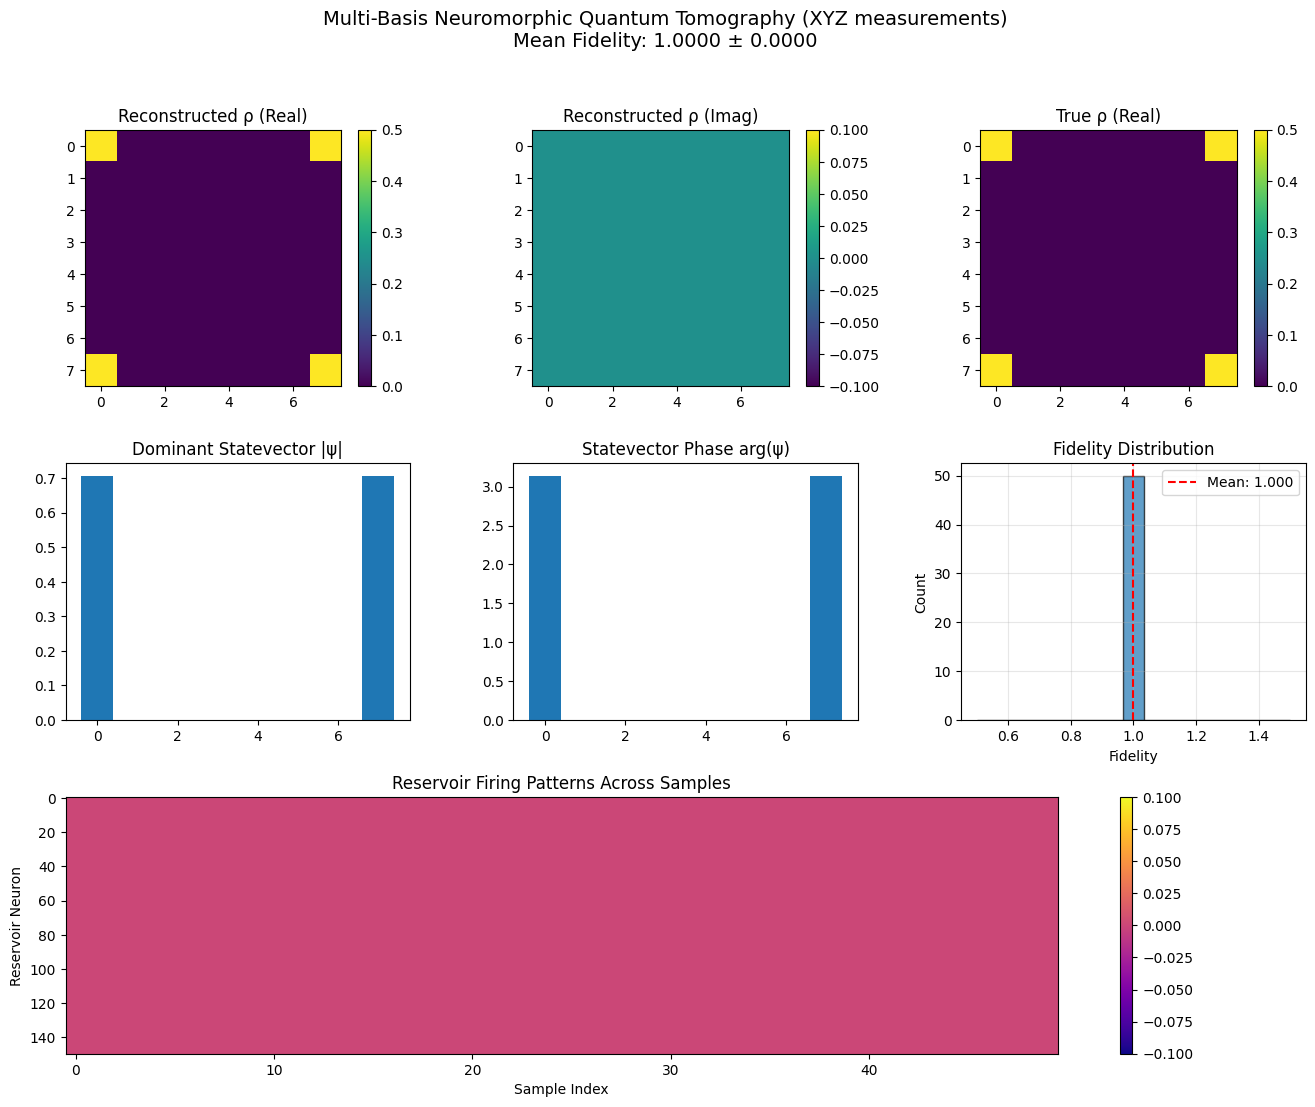

In [23]:
# Installation: pip install snntorch pennylane scikit-learn matplotlib torch

import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
import pennylane as qml
from pennylane import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_qubits = 3
input_size = 3 * (2 ** num_qubits)  # 3 bases × 2^n measurement outcomes
reservoir_size = 150  # Increased for richer input
time_steps = 50
num_training_samples = 50
measurement_shots = 1000
max_rate_hz = 100

print(f"Device: {device}")
print(f"Qubits: {num_qubits}, Input size: {input_size}, Reservoir: {reservoir_size}")
print(f"Time steps: {time_steps}, Samples: {num_training_samples}")

# PennyLane devices for different basis measurements
dev_meas = qml.device("default.qubit", wires=num_qubits, shots=measurement_shots)
dev_state = qml.device("default.qubit", wires=num_qubits, shots=None)

# Z-basis measurement (computational basis)
@qml.qnode(dev_meas)
def measure_z_basis():
    qml.Hadamard(wires=0)
    for i in range(num_qubits - 1):
        qml.CNOT(wires=[i, i+1])
    return qml.sample(wires=range(num_qubits))

# X-basis measurement (Hadamard before measurement)
@qml.qnode(dev_meas)
def measure_x_basis():
    qml.Hadamard(wires=0)
    for i in range(num_qubits - 1):
        qml.CNOT(wires=[i, i+1])
    # Apply Hadamard to all qubits for X-basis measurement
    for i in range(num_qubits):
        qml.Hadamard(wires=i)
    return qml.sample(wires=range(num_qubits))

# Y-basis measurement (S† + Hadamard before measurement)
@qml.qnode(dev_meas)
def measure_y_basis():
    qml.Hadamard(wires=0)
    for i in range(num_qubits - 1):
        qml.CNOT(wires=[i, i+1])
    # Apply S† + Hadamard to all qubits for Y-basis measurement
    for i in range(num_qubits):
        qml.adjoint(qml.S)(wires=i)  # S† gate
        qml.Hadamard(wires=i)
    return qml.sample(wires=range(num_qubits))

# True state preparation for targets
@qml.qnode(dev_state)
def prepare_state():
    qml.Hadamard(wires=0)
    for i in range(num_qubits - 1):
        qml.CNOT(wires=[i, i+1])
    return qml.state()

def state_to_density_matrix(state_vec):
    return np.outer(state_vec, np.conj(state_vec))

# Generate Poisson spikes from rates
def generate_poisson_spikes(rates, time_steps, dt=1.0):
    prob = rates * dt / 1000  # Convert Hz to probability per timestep
    prob = torch.clamp(prob, 0, 1)
    spikes = torch.rand(time_steps, len(rates)) < prob
    return spikes.float()

# Convert measurement samples to rates for each basis
def samples_to_rates(samples, max_rate=max_rate_hz):
    counts = {}
    total = len(samples)
    for s in samples:
        bitstr = ''.join(str(int(b)) for b in s)
        counts[bitstr] = counts.get(bitstr, 0) + 1
    freqs = [counts.get(f"{i:0{num_qubits}b}", 0)/total for i in range(2**num_qubits)]
    return torch.tensor(freqs, dtype=torch.float) * max_rate

# Multi-basis measurement data collection
def collect_multi_basis_measurements():
    # Collect measurements from all three Pauli bases
    z_samples = measure_z_basis()
    x_samples = measure_x_basis()
    y_samples = measure_y_basis()

    # Convert each to rates
    z_rates = samples_to_rates(z_samples)
    x_rates = samples_to_rates(x_samples)
    y_rates = samples_to_rates(y_samples)

    # Concatenate all basis measurements
    combined_rates = torch.cat([z_rates, x_rates, y_rates])
    return combined_rates

# Enhanced spiking reservoir network
class MultiAxisSNNReservoir(nn.Module):
    def __init__(self, input_size, reservoir_size):
        super().__init__()
        self.input_size = input_size
        self.reservoir_size = reservoir_size

        # Input projection layers for different bases
        self.W_in = nn.Linear(input_size, reservoir_size, bias=False)
        self.W_rec = nn.Linear(reservoir_size, reservoir_size, bias=False)

        # LIF parameters
        self.beta = 0.85  # membrane decay
        self.threshold = 1.0

        # Initialize weights
        with torch.no_grad():
            # Input weights with Xavier initialization
            nn.init.xavier_uniform_(self.W_in.weight, gain=0.5)
            # Recurrent weights with spectral radius control
            self.W_rec.weight.data *= 0.4

    def forward(self, spike_inputs):
        batch_size = 1
        time_steps = spike_inputs.size(0)

        # Initialize states
        mem = torch.zeros(batch_size, self.reservoir_size, device=spike_inputs.device)
        spike_counts = torch.zeros(self.reservoir_size, device=spike_inputs.device)

        spk = torch.zeros(batch_size, self.reservoir_size, device=spike_inputs.device)

        for t in range(time_steps):
            # Input current
            input_current = self.W_in(spike_inputs[t].unsqueeze(0))

            # Recurrent current
            rec_current = self.W_rec(spk) if t > 0 else 0

            # Membrane potential update
            mem = self.beta * mem + input_current + rec_current

            # Spike generation
            spk = (mem >= self.threshold).float()
            spike_counts += spk.squeeze(0)

            # Reset after spike
            mem = mem * (1 - spk)

        return spike_counts / time_steps

# Initialize enhanced reservoir
reservoir = MultiAxisSNNReservoir(input_size, reservoir_size).to(device)

# Training with multi-basis measurements
reservoir_states = []
target_density_mats = []

print("Collecting multi-basis measurement data...")
for sample_idx in range(num_training_samples):
    # Collect measurements from X, Y, Z bases
    combined_rates = collect_multi_basis_measurements().to(device)

    # Generate spike trains
    spike_inputs = generate_poisson_spikes(combined_rates, time_steps).to(device)

    # Process through spiking reservoir
    with torch.no_grad():
        firing_rates = reservoir(spike_inputs)

    reservoir_states.append(firing_rates.cpu().numpy())

    # Get true target density matrix
    true_state = prepare_state()
    dm = state_to_density_matrix(true_state)
    target_density_mats.append(dm)

    if (sample_idx + 1) % 10 == 0:
        print(f"Processed {sample_idx + 1}/{num_training_samples} samples")

reservoir_states = np.array(reservoir_states)
target_density_mats = np.array(target_density_mats)

# Prepare targets for regression
dim = 2 ** num_qubits
targets = np.hstack([target_density_mats.real.reshape(num_training_samples, -1),
                     target_density_mats.imag.reshape(num_training_samples, -1)])

# Ridge regression training
print("Training regression model...")
reg = Ridge(alpha=1.0)  # Regularization for stability
reg.fit(reservoir_states, targets)
predictions = reg.predict(reservoir_states)

# Fidelity computation
def fidelity_batch(true_dm, pred_dm, dim=2**num_qubits):
    fidelities = []
    for t, p in zip(true_dm, pred_dm):
        t_dm = t[:dim*dim].reshape((dim, dim)) + 1j * t[dim*dim:].reshape((dim, dim))
        p_dm = p[:dim*dim].reshape((dim, dim)) + 1j * p[dim*dim:].reshape((dim, dim))
        fidelities.append(qml.math.fidelity(t_dm, p_dm))
    return np.array(fidelities)

fidelities = fidelity_batch(targets, predictions)
print(f"\nResults:")
print(f"Average fidelity: {np.mean(fidelities):.4f}")
print(f"Std fidelity: {np.std(fidelities):.4f}")
print(f"Min fidelity: {np.min(fidelities):.4f}")
print(f"Max fidelity: {np.max(fidelities):.4f}")

# Enhanced visualization
fig = plt.figure(figsize=(16, 12))

# Density matrix visualization
pred_dm = predictions[0, :dim*dim].reshape((dim, dim)) + 1j * predictions[0, dim*dim:].reshape((dim, dim))
true_dm = target_density_mats[0]

gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Reconstructed density matrix
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(pred_dm.real, cmap='viridis')
ax1.set_title("Reconstructed ρ (Real)")
plt.colorbar(im1, ax=ax1)

ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(pred_dm.imag, cmap='viridis')
ax2.set_title("Reconstructed ρ (Imag)")
plt.colorbar(im2, ax=ax2)

# True density matrix
ax3 = fig.add_subplot(gs[0, 2])
im3 = ax3.imshow(true_dm.real, cmap='viridis')
ax3.set_title("True ρ (Real)")
plt.colorbar(im3, ax=ax3)

# Dominant eigenvector
eigvals, eigvecs = np.linalg.eigh(pred_dm)
dominant_vec = eigvecs[:, np.argmax(eigvals)]

ax4 = fig.add_subplot(gs[1, 0])
ax4.bar(range(dim), np.abs(dominant_vec))
ax4.set_title("Dominant Statevector |ψ|")

ax5 = fig.add_subplot(gs[1, 1])
ax5.bar(range(dim), np.angle(dominant_vec))
ax5.set_title("Statevector Phase arg(ψ)")

# Fidelity distribution
ax6 = fig.add_subplot(gs[1, 2])
ax6.hist(fidelities, bins=15, alpha=0.7, edgecolor='black')
ax6.axvline(np.mean(fidelities), color='red', linestyle='--',
           label=f'Mean: {np.mean(fidelities):.3f}')
ax6.set_xlabel('Fidelity')
ax6.set_ylabel('Count')
ax6.set_title('Fidelity Distribution')
ax6.legend()
ax6.grid(True, alpha=0.3)

# Reservoir activity heatmap
ax7 = fig.add_subplot(gs[2, :])
im7 = ax7.imshow(reservoir_states.T, cmap='plasma', aspect='auto')
ax7.set_xlabel('Sample Index')
ax7.set_ylabel('Reservoir Neuron')
ax7.set_title('Reservoir Firing Patterns Across Samples')
plt.colorbar(im7, ax=ax7)

plt.suptitle(f'Multi-Basis Neuromorphic Quantum Tomography (XYZ measurements)\n'
             f'Mean Fidelity: {np.mean(fidelities):.4f} ± {np.std(fidelities):.4f}',
             fontsize=14)

plt.show()
